In [1]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt

In [2]:
transform=T.Compose([
    T.Resize((128,128)),
    T.ToTensor(),
])

In [3]:
img_dirs = [
    "/kaggle/input/leaf-disease-segmentation-dataset/data/data/images",
    "/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images"
]
mask_dirs = [
    "/kaggle/input/leaf-disease-segmentation-dataset/data/data/masks",
    "/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/masks"
]


In [4]:
for img_dir, mask_dir in zip(img_dirs, mask_dirs):
    img_names = sorted(os.listdir(img_dir))
    mask_names = sorted(os.listdir(mask_dir))
    for img, mask in zip(img_names[:3], mask_names[:3]):
        print(img, "<->", mask)
    for img, mask in zip(img_names, mask_names):
        if os.path.splitext(img)[0] != os.path.splitext(mask)[0]:
            print("Mismatch:", img, mask)

00000.jpg <-> 00000.png
00001.jpg <-> 00001.png
00002.jpg <-> 00002.png
00000_0.jpg <-> 00000_0.png
00000_1.jpg <-> 00000_1.png
00000_2.jpg <-> 00000_2.png


In [32]:

class LeafDataset(Dataset):
    def __init__(self,img_dirs,mask_dirs,transform=None,mask_size=(128,128)):
        self.img_paths=[]
        self.mask_paths=[]
        self.mask_size = mask_size
        for img_dir,mask_dir in zip(img_dirs,mask_dirs):
            img_names=sorted(os.listdir(img_dir))
            mask_names = sorted(os.listdir(mask_dir))
            self.img_paths += [os.path.join(img_dir, name) for name in img_names]
            self.mask_paths += [os.path.join(mask_dir, name) for name in mask_names]
        self.transform = transform
    def __len__(self):
        return len(self.img_paths)
    def __getitem__(self, idx):
        image = Image.open(self.img_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")
        mask = mask.resize(self.mask_size, resample=Image.NEAREST)
        mask = np.array(mask)
        mask = (mask > 1).astype("float32")   # PURE 0 or 1
        mask = torch.tensor(mask).unsqueeze(0)
        if self.transform:
            image = self.transform(image)
        return image, mask

In [33]:
dataset = LeafDataset(img_dirs, mask_dirs, transform=transform)
loader = DataLoader(dataset, batch_size=8, shuffle=True,num_workers=2)


In [9]:
import numpy as np

In [21]:
mask = Image.open(dataset.mask_paths[0]).convert("L")
mask_np = np.array(mask)

print("Unique RAW mask values:", np.unique(mask_np))

Unique RAW mask values: [ 0 38]


[0. 1.]


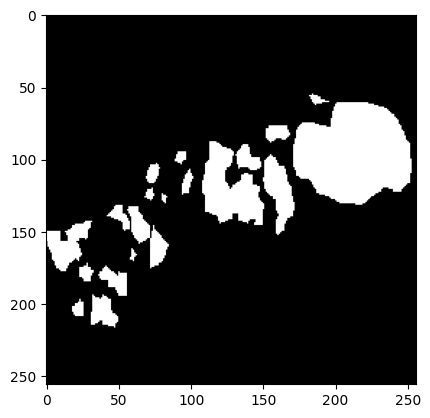

In [12]:
mask_np = mask.squeeze().cpu().numpy()
plt.imshow(mask_np, cmap='gray')
print(np.unique(mask_np))

In [22]:
for i in range(3):
    img, mask = dataset[i]

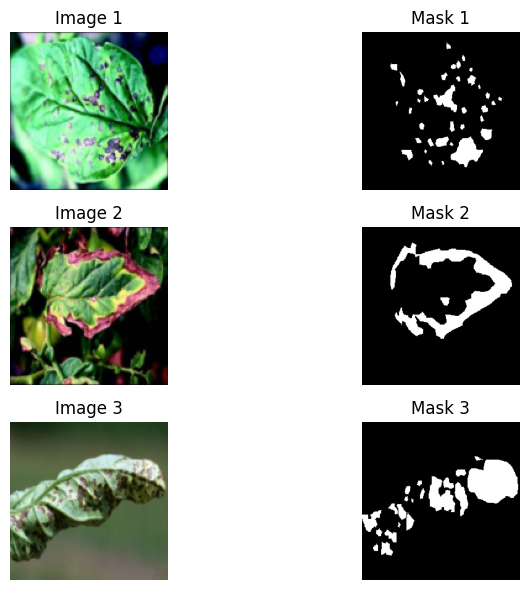

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,6))
for i in range(3):
    img, mask = dataset[i]
    # Convert img tensor to numpy for plotting: (C, H, W) → (H, W, C)
    img_np = img.permute(1,2,0).cpu().numpy()
    # Convert mask tensor to numpy and squeeze channel
    mask_np = mask.squeeze().cpu().numpy()
    
    # Show image
    plt.subplot(3,2,i*2+1)
    plt.imshow(img_np)
    plt.title(f"Image {i+1}")
    plt.axis('off')
    
    # Show mask
    plt.subplot(3,2,i*2+2)
    plt.imshow(mask_np, cmap='gray')
    plt.title(f"Mask {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [14]:
!pip install -U segmentation-models-pytorch --quiet
!pip install -U pretrainedmodels --quiet
!pip install -U efficientnet-pytorch --quiet
import segmentation_models_pytorch as smp

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [34]:
model = smp.Unet(
    encoder_name='resnet34',      # Encoder backbone
    in_channels=3,                # Number of input channels (RGB)
    classes=1                     # Number of output classes (binary mask)
)

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
bce = torch.nn.BCEWithLogitsLoss()
dice = smp.losses.DiceLoss(mode='binary')
def combined_loss(pred,mask):
    return 0.5*bce(pred,mask)+0.5*dice(pred,mask)


In [36]:
def dice_score(pred_mask, true_mask, eps=1e-6):
    pred_mask = (pred_mask > 0.3).float()
    intersection = (pred_mask * true_mask).sum()
    union = pred_mask.sum() + true_mask.sum()
    return (2 * intersection + eps) / (union + eps)

def iou_score(pred_mask, true_mask, eps=1e-6):
    pred_mask = (pred_mask > 0.3).float()
    intersection = (pred_mask * true_mask).sum()
    union = pred_mask.sum() + true_mask.sum() - intersection
    return (intersection + eps) / (union + eps)


In [37]:
epochs = 10
best_loss=float("inf")
for epoch in range(epochs):
    model.train()
    total_loss = 0
    total_dice = 0
    total_iou = 0
    for imgs, masks in loader:
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        loss = combined_loss(preds, masks)
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        #METRICS
        preds_sigmoid = torch.sigmoid(preds)
        dice_val = dice_score(preds_sigmoid, masks)
        iou_val = iou_score(preds_sigmoid, masks)

        total_dice += dice_val.item()
        total_iou += iou_val.item()

    avg_loss = total_loss / len(loader)
    avg_dice = total_dice / len(loader)
    avg_iou = total_iou / len(loader)
    print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f}| Dice: {avg_dice:.4f} | IOU: {avg_iou:.4f}")
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), "unet_leaf_best.pth")
        print("🔥 Saved Best Model!")


Epoch 1/10 | Loss: 0.3757| Dice: 0.6186 | IOU: 0.4558
🔥 Saved Best Model!
Epoch 2/10 | Loss: 0.3069| Dice: 0.6888 | IOU: 0.5317
🔥 Saved Best Model!
Epoch 3/10 | Loss: 0.2780| Dice: 0.7201 | IOU: 0.5687
🔥 Saved Best Model!
Epoch 4/10 | Loss: 0.2560| Dice: 0.7430 | IOU: 0.5974
🔥 Saved Best Model!
Epoch 5/10 | Loss: 0.2381| Dice: 0.7609 | IOU: 0.6198
🔥 Saved Best Model!
Epoch 6/10 | Loss: 0.2285| Dice: 0.7709 | IOU: 0.6323
🔥 Saved Best Model!
Epoch 7/10 | Loss: 0.2108| Dice: 0.7902 | IOU: 0.6585
🔥 Saved Best Model!
Epoch 8/10 | Loss: 0.1994| Dice: 0.8021 | IOU: 0.6744
🔥 Saved Best Model!
Epoch 9/10 | Loss: 0.1926| Dice: 0.8080 | IOU: 0.6826
🔥 Saved Best Model!
Epoch 10/10 | Loss: 0.1798| Dice: 0.8214 | IOU: 0.7010
🔥 Saved Best Model!


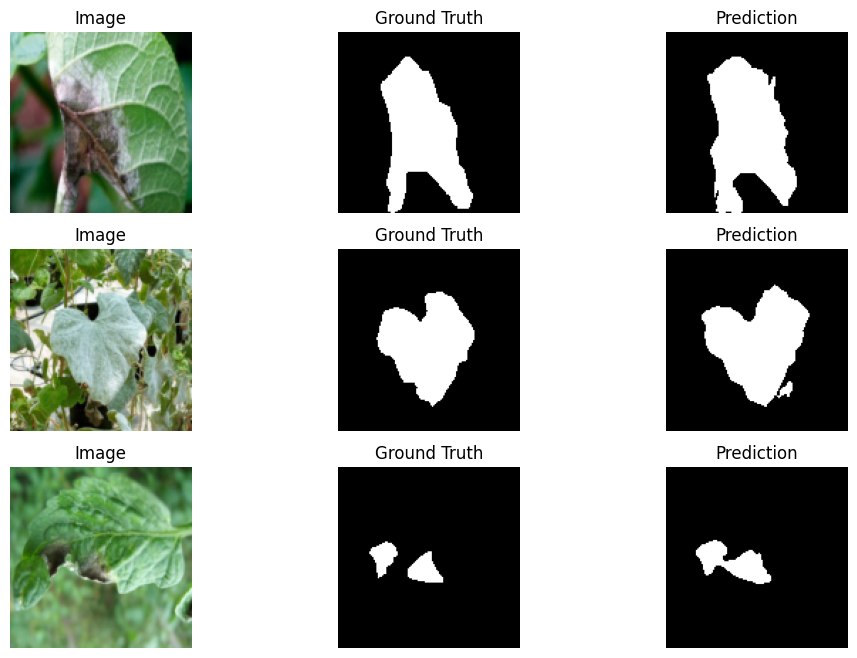

In [38]:
model.eval()
imgs, masks = next(iter(loader))
imgs, masks = imgs.to(device), masks.to(device)
with torch.no_grad():
    preds = torch.sigmoid(model(imgs))
    preds = (preds > 0.3).float()

# Display sample results
plt.figure(figsize=(12,8))
for i in range(3):
    plt.subplot(3,3,i*3+1)
    plt.imshow(imgs[i].cpu().permute(1,2,0))
    plt.title("Image")
    plt.axis('off')
    plt.subplot(3,3,i*3+2)
    plt.imshow(masks[i].cpu().squeeze(), cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')
    plt.subplot(3,3,i*3+3)
    plt.imshow(preds[i].cpu().squeeze(), cmap='gray')
    plt.title("Prediction")
    plt.axis('off')
plt.savefig("Segmentation_output.png",bbox_inches='tight')
plt.show()


In [ ]:
'''model = smp.Unet(
    encoder_name='resnet18',
    in_channels=3,
    classes=1
)
model.load_state_dict(torch.load("unet_leaf_segmentation.pth", map_location='cpu'))
model.eval()'''